### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# carregar o .env com as credenciais
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")


# detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"


# parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.sales-salesterritory"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"


# configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


#doc: tables_to_process: lista de tabelas que serão processadas
#     output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned

In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.sales-salesterritory']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productcosthistory
production-productinventory
production-productsubcategory
purchasing-purchaseorderdetail
purchasing-purchaseorderheader
purchasing-vendor
sales-creditcard
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Setup inicial do df para realizar a EDA 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.raw_data.sales-salesterritory
Lendo os dados do BigQuery...
Tabela sales_salesterritory processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: sales_salesterritory


In [7]:
# Atribuir o df a uma variável com nome mais simples
sales_salesterritory = df_processados['sales_salesterritory']

print(f"Colunas: {sales_salesterritory.shape[1]}\nLinhas: {sales_salesterritory.shape[0]}")

Colunas: 10
Linhas: 130


In [8]:
# Identificar duplicadas
duplicadas = sales_salesterritory[sales_salesterritory.duplicated(subset=['territoryid'], keep=False)]

# Verificar se existem duplicadas
if not duplicadas.empty:
    
    duplicadas_ordenadas = duplicadas.sort_values(by=['territoryid', 'modifieddate'])

    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
    territoryid            name countryregioncode          group   salesytd  saleslastyear  costytd  costlastyear                               rowguid              modifieddate
52            1       Northwest                US  North America 7887186.79     3298694.49        0             0  43689a10-e30b-497f-b0de-11de20267ff7 2008-04-30 00:00:00+00:00
53            1       Northwest                US  North America 7887186.79     3298694.49        0             0  43689a10-e30b-497f-b0de-11de20267ff7 2008-04-30 00:00:00+00:00
54            1       Northwest                US  North America 7887186.79     3298694.49        0             0  43689a10-e30b-497f-b0de-11de20267ff7 2008-04-30 00:00:00+00:00
55            1       Northwest                US  North America 7887186.79     3298694.49        0             0  43689a10-e30b-497f-b0de-11de20267ff7 2008-04-30 00:00:00+00:00
56            1       Northwest                US  North America 7887186.79     3298694.

In [9]:
# Remover duplicadas* 
sales_salesterritory = sales_salesterritory.drop_duplicates(subset=['territoryid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(sales_salesterritory)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = sales_salesterritory.copy()


#doc: bkp = backup (cópia)
#doc*: mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
#      Importante, pois se houver erro na ingestão (duplicação), mantém os dados íntegros.

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 10


In [10]:
# Ordenar e exibir o df por 'territoryid'
sales_salesterritory = sales_salesterritory.sort_values(by=['territoryid'])

print(sales_salesterritory)

     territoryid            name countryregioncode          group    salesytd  saleslastyear  costytd  costlastyear                               rowguid              modifieddate
64             1       Northwest                US  North America  7887186.79     3298694.49        0             0  43689a10-e30b-497f-b0de-11de20267ff7 2008-04-30 00:00:00+00:00
77             2       Northeast                US  North America  2402176.85     3607148.94        0             0  00fb7309-96cc-49e2-8363-0a1ba72486f2 2008-04-30 00:00:00+00:00
90             3         Central                US  North America  3072175.12     3205014.08        0             0  df6e7fd8-1a8d-468c-b103-ed8addb452c1 2008-04-30 00:00:00+00:00
103            4       Southwest                US  North America 10510853.87     5366575.71        0             0  dc3e9ea0-7950-4431-9428-99dbcbc33865 2008-04-30 00:00:00+00:00
116            5       Southeast                US  North America  2538667.25     3925071.43        

In [11]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in sales_salesterritory.columns:   
    missing_rows = sales_salesterritory[sales_salesterritory[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'territoryid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'territoryid'.

Coluna 'name': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'name'.

Coluna 'countryregioncode': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'countryregioncode'.

Coluna 'group': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'group'.

Coluna 'salesytd': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'salesytd'.

Coluna 'saleslastyear': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'saleslastyear'.

Coluna 'costytd': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'costytd'.

Coluna 'costlastyear': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'costlastyear'.

Coluna 'rowguid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'rowguid'.

Coluna 'modifieddate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'modifieddate'.



In [12]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = sales_salesterritory.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

Valores únicos incluindo NaN:
territoryid          10
name                 10
countryregioncode     6
group                 3
salesytd             10
saleslastyear        10
costytd               1
costlastyear          1
rowguid              10
modifieddate          1
dtype: int64


In [13]:
# Identificar colunas com apenas 1 valor único (incluindo NaN)
colunas_com_1_valor = valores_unicos[valores_unicos == 1].index

# Exibir os valores únicos dessas colunas
print("Colunas com apenas 1 valor único:")
for col in colunas_com_1_valor:
    valor_unico = sales_salesterritory[col].unique()
    print(f"{col}: {valor_unico}")


Colunas com apenas 1 valor único:
costytd: <IntegerArray>
[0]
Length: 1, dtype: Int64
costlastyear: <IntegerArray>
[0]
Length: 1, dtype: Int64
modifieddate: <DatetimeArray>
['2008-04-30 00:00:00+00:00']
Length: 1, dtype: datetime64[us, UTC]


In [14]:
# Identificar colunas com valor único igual a 0
colunas_para_remover = [col for col in sales_salesterritory.columns if sales_salesterritory[col].nunique() == 1 and sales_salesterritory[col].unique()[0] == 0]

sales_salesterritory = sales_salesterritory.drop(columns=colunas_para_remover)

print("Colunas restantes no DataFrame:")
print(sales_salesterritory.columns.tolist())

print("\nDataFrame atualizado:")
print(sales_salesterritory)


#doc*: as colunas costytf e Length apresentaram todas as linhas com o valor 0, portanto, sem valor agregado as análises - colunas deletadas
#      mantive a coluna modifieddate, por se tratar de datas e ser fundamental em análises futuras

Colunas restantes no DataFrame:
['territoryid', 'name', 'countryregioncode', 'group', 'salesytd', 'saleslastyear', 'rowguid', 'modifieddate']

DataFrame atualizado:
     territoryid            name countryregioncode          group    salesytd  saleslastyear                               rowguid              modifieddate
64             1       Northwest                US  North America  7887186.79     3298694.49  43689a10-e30b-497f-b0de-11de20267ff7 2008-04-30 00:00:00+00:00
77             2       Northeast                US  North America  2402176.85     3607148.94  00fb7309-96cc-49e2-8363-0a1ba72486f2 2008-04-30 00:00:00+00:00
90             3         Central                US  North America  3072175.12     3205014.08  df6e7fd8-1a8d-468c-b103-ed8addb452c1 2008-04-30 00:00:00+00:00
103            4       Southwest                US  North America 10510853.87     5366575.71  dc3e9ea0-7950-4431-9428-99dbcbc33865 2008-04-30 00:00:00+00:00
116            5       Southeast                US

In [15]:
sales_salesterritory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 64 to 38
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   territoryid        10 non-null     Int64              
 1   name               10 non-null     object             
 2   countryregioncode  10 non-null     object             
 3   group              10 non-null     object             
 4   salesytd           10 non-null     float64            
 5   saleslastyear      10 non-null     float64            
 6   rowguid            10 non-null     object             
 7   modifieddate       10 non-null     datetime64[us, UTC]
dtypes: Int64(1), datetime64[us, UTC](1), float64(2), object(4)
memory usage: 730.0+ bytes


In [16]:
#avaliando as variáveis qualitativas*

coluna_quantitativa = ["name", "countryregioncode", "group"]
for col in coluna_quantitativa:
    counts = sales_salesterritory[col].value_counts().nlargest(10)
    percentages = (counts / sales_salesterritory.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(summary)    


#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente
#      no nosso caso, name, countryregioncode, group, por exemplo

                qtde.       %
name                         
Northwest           1  10.00%
Northeast           1  10.00%
Central             1  10.00%
Southwest           1  10.00%
Southeast           1  10.00%
Canada              1  10.00%
France              1  10.00%
Germany             1  10.00%
Australia           1  10.00%
United Kingdom      1  10.00%
                   qtde.       %
countryregioncode               
US                     5  50.00%
CA                     1  10.00%
FR                     1  10.00%
DE                     1  10.00%
AU                     1  10.00%
GB                     1  10.00%
               qtde.       %
group                       
North America      6  60.00%
Europe             3  30.00%
Pacific            1  10.00%


C:\Users\wrpen\AppData\Local\Temp\ipykernel_7608\942591831.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis')


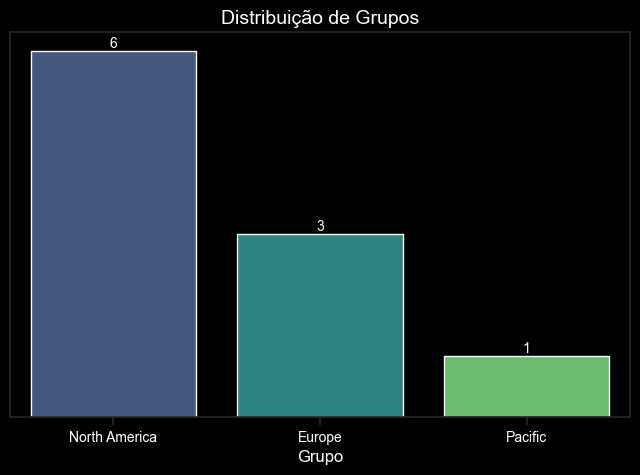

In [17]:
#dominância geográfica*

group_counts = sales_salesterritory['group'].value_counts()


sns.set(style='ticks', rc={"axes.facecolor": "black", "figure.facecolor": "black"})
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis')
plt.title("Distribuição de Grupos", color='white', fontsize=14)
plt.xlabel("Grupo", color='white', fontsize=12)
plt.ylabel("", fontsize=12)  
plt.xticks(color='white', fontsize=10)
ax.tick_params(axis='y', left=False, labelleft=False)
ax.grid(False)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', color='white', fontsize=10, label_type='edge')

plt.show()



#doc*: a região North America domina com 60% das ocorrências no grupo,
#      o código de país US representa 50% dos dados e CA repsenta 10%  

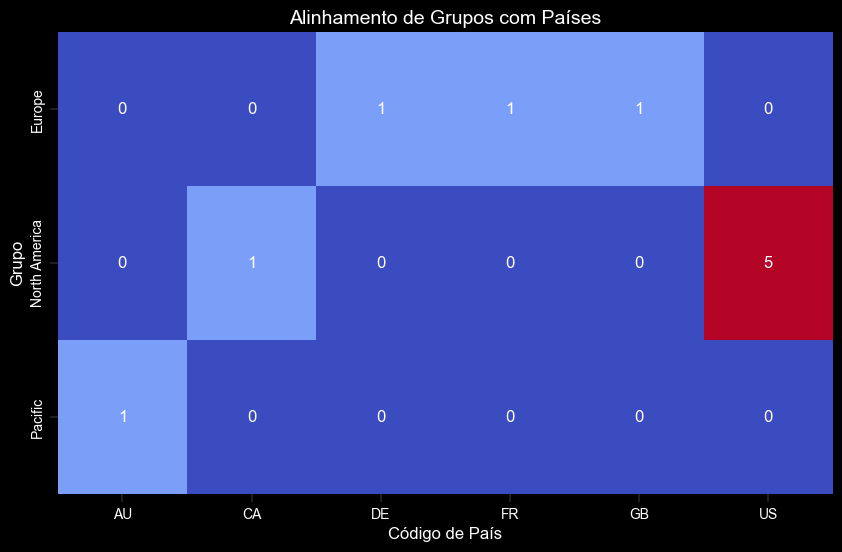

In [18]:
# alinhamento de grupos com países*

group_country = sales_salesterritory.groupby(['group', 'countryregioncode']).size().unstack(fill_value=0)

# Heatmap para visualização
plt.figure(figsize=(10, 6))
sns.heatmap(group_country, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Alinhamento de Grupos com Países", color='white', fontsize=14)
plt.xlabel("Código de País", color='white', fontsize=12)
plt.ylabel("Grupo", color='white', fontsize=12)
plt.xticks(color='white', fontsize=10)
plt.yticks(color='white', fontsize=10)

plt.show()


#doc*: identificar quais países pertencem a quais grupos e se há algum desequilíbrio na distribuição (North America: US=5;CA=1)
#      entender a relação entre grupos e países ajuda a otimizar operações regionais, ajustar estratégias de marketing e identificar áreas de oportunidades de crescimento.
#      grupos sub-representados em países específicos podem indicar mercados a serem explorados

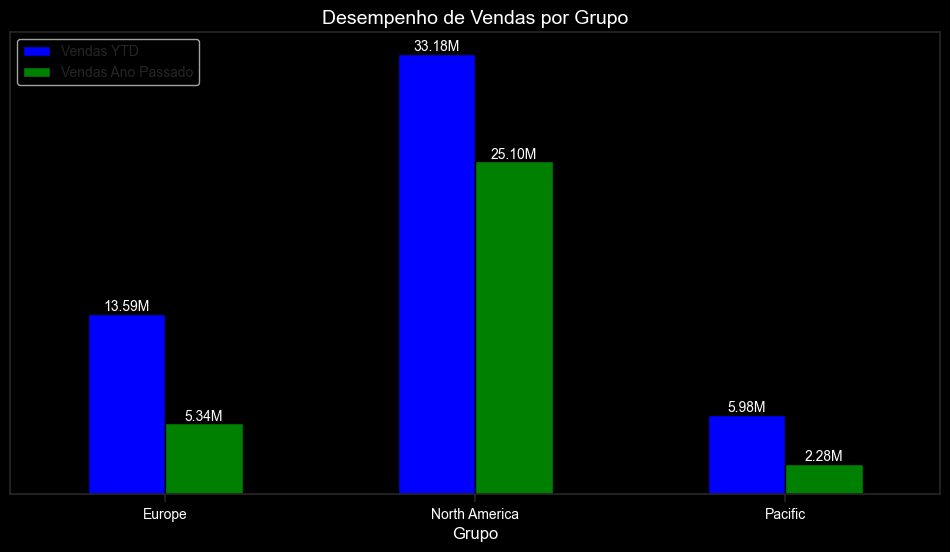

In [19]:
# Desempenho de vendas por grupo*

#soma salesytd e saleslastyear**
group_performance = sales_salesterritory.groupby('group')[['salesytd', 'saleslastyear']].sum()

fig, ax = plt.subplots(figsize=(12, 6))
group_performance.plot(kind='bar', color=['blue', 'green'], edgecolor='black', ax=ax)
plt.title("Desempenho de Vendas por Grupo", color='white', fontsize=14)
plt.xlabel("Grupo", color='white', fontsize=12)
plt.ylabel("Vendas", color='white', fontsize=12)
plt.xticks(color='white', fontsize=10, rotation=0)
ax.yaxis.set_visible(False)
plt.legend(['Vendas YTD', 'Vendas Ano Passado'], fontsize=10, loc='upper left')

for container in ax.containers:
    labels = [f'{value / 1_000_000:.2f}M' for value in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', color='white', fontsize=10)

plt.show()



#doc*: comparar o desempenho de vendas entre os diferentes grupos com base nas métricas "salesytd" (vendas acumuladas no ano) e "saleslastyear" (vendas do ano passado)
#      grupos com desempenho consistente indicam estabilidade e podem ser mantidos
#      grupos com queda nas vendas requerem atenção para identificar e corrigir problemas


#doc: vendas YTD (Year-to-Date): representa o total acumulado de vendas desde o início do ano até a data atual.Útil para avaliar o desempenho atual em relação ao ano anterior
#       vendas do Ano Passado (Last Year): refere-se ao total de vendas realizadas durante o ano anterior completo. Comparação para identificar tendências de crescimento ou declínio ao longo do tempo


#doc: as colunas 'salesytd' e 'saleslastyear' não são calculadas dinamicamente,elas representam valores acumulados registrados na base de dados até a data 
#     informada em 'modifieddate', que é 2008-04-30 para todos os registros

C:\Users\wrpen\AppData\Local\Temp\ipykernel_7608\3527384601.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=country_performance.index, y=country_performance.values, palette='mako')


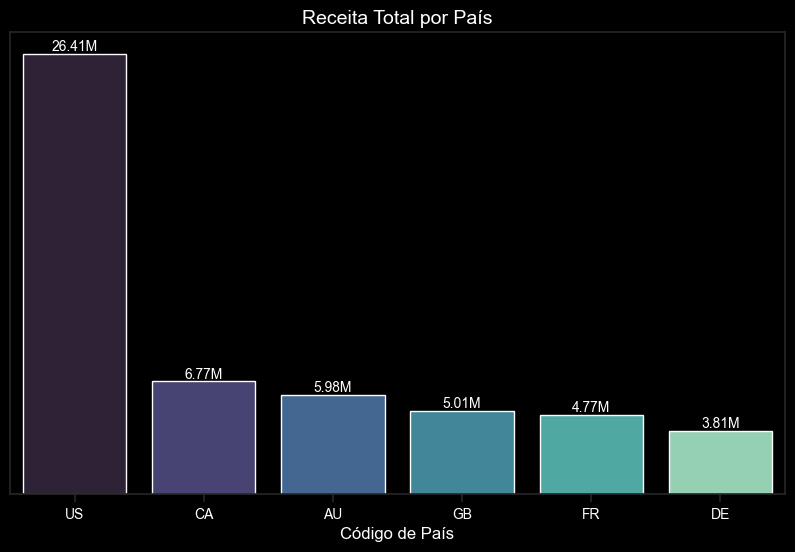

In [20]:
# Receita total por país*
country_performance = sales_salesterritory.groupby('countryregioncode')['salesytd'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=country_performance.index, y=country_performance.values, palette='mako')
plt.title("Receita Total por País", color='white', fontsize=14)
plt.xlabel("Código de País", color='white', fontsize=12)
plt.ylabel("", fontsize=12)  
plt.xticks(color='white', fontsize=10)
ax.tick_params(axis='y', left=False, labelleft=False)

for container in ax.containers:
    labels = [f'{value / 1_000_000:.2f}M' for value in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', color='white', fontsize=10)
    
plt.show()



# doc*:representação da receita total (SalesYTD) acumulada por país, destacando quais nações geraram mais receita,
#      ajuda a entender a distribuição geográfica das vendas e a identificar mercados mais lucrativos para a empresa

# doc: países com maior receita, como os no topo do gráfico, são os principais contribuintes para o faturamento,
#      comparação direta entre países auxilia na análise de desempenho regional e na alocação de recursos

#doc: a coluna 'salesytd' não é calculada dinamicamente,ela representa valores acumulados registrados na base de dados até a data 
#     informada em 'modifieddate', que é 2008-04-30 para todos os registros

In [21]:
sales_salesterritory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 64 to 38
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   territoryid        10 non-null     Int64              
 1   name               10 non-null     object             
 2   countryregioncode  10 non-null     object             
 3   group              10 non-null     object             
 4   salesytd           10 non-null     float64            
 5   saleslastyear      10 non-null     float64            
 6   rowguid            10 non-null     object             
 7   modifieddate       10 non-null     datetime64[us, UTC]
dtypes: Int64(1), datetime64[us, UTC](1), float64(2), object(4)
memory usage: 730.0+ bytes


In [22]:
# Variáveis quantitativas*

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['salesytd', 'saleslastyear']

# Estatísticas Descritivas das colunas numéricas*
print(sales_salesterritory[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)**
for col in numeric_columns:
    q1 = sales_salesterritory[col].quantile(0.25)
    q3 = sales_salesterritory[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers***
    outliers = sales_salesterritory[(sales_salesterritory[col] < lower_bound) | (sales_salesterritory[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])


#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas
#doc*: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc**: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc***: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados
#doc****: as colunas analisadas não apresentam outliers, pois os dados estão dentro dos limites esperados, sugerindo que não há necessidade de tratamento adicional para valores extremos,
#         isso indica boa qualidade dos dados para essas variáveis e que elas estão prontas para serem exportadas ou utilizadas em análises e modelos

         salesytd  saleslastyear
count       10.00          10.00
mean   5275121.00     3271535.54
std    2582995.81     1456222.08
min    2402176.85     1307949.79
25%    3255431.93     2308046.67
50%    4892651.84     3251854.29
75%    6573325.58     3845590.81
max   10510853.87     5693988.86

Coluna: salesytd
Limite inferior: -1721408.5594500005, Limite superior: 11550166.06695
Outliers detectados (0):
Empty DataFrame
Columns: [salesytd]
Index: []

Coluna: saleslastyear
Limite inferior: 1730.4708750001155, Limite superior: 6151907.010475
Outliers detectados (0):
Empty DataFrame
Columns: [saleslastyear]
Index: []


c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


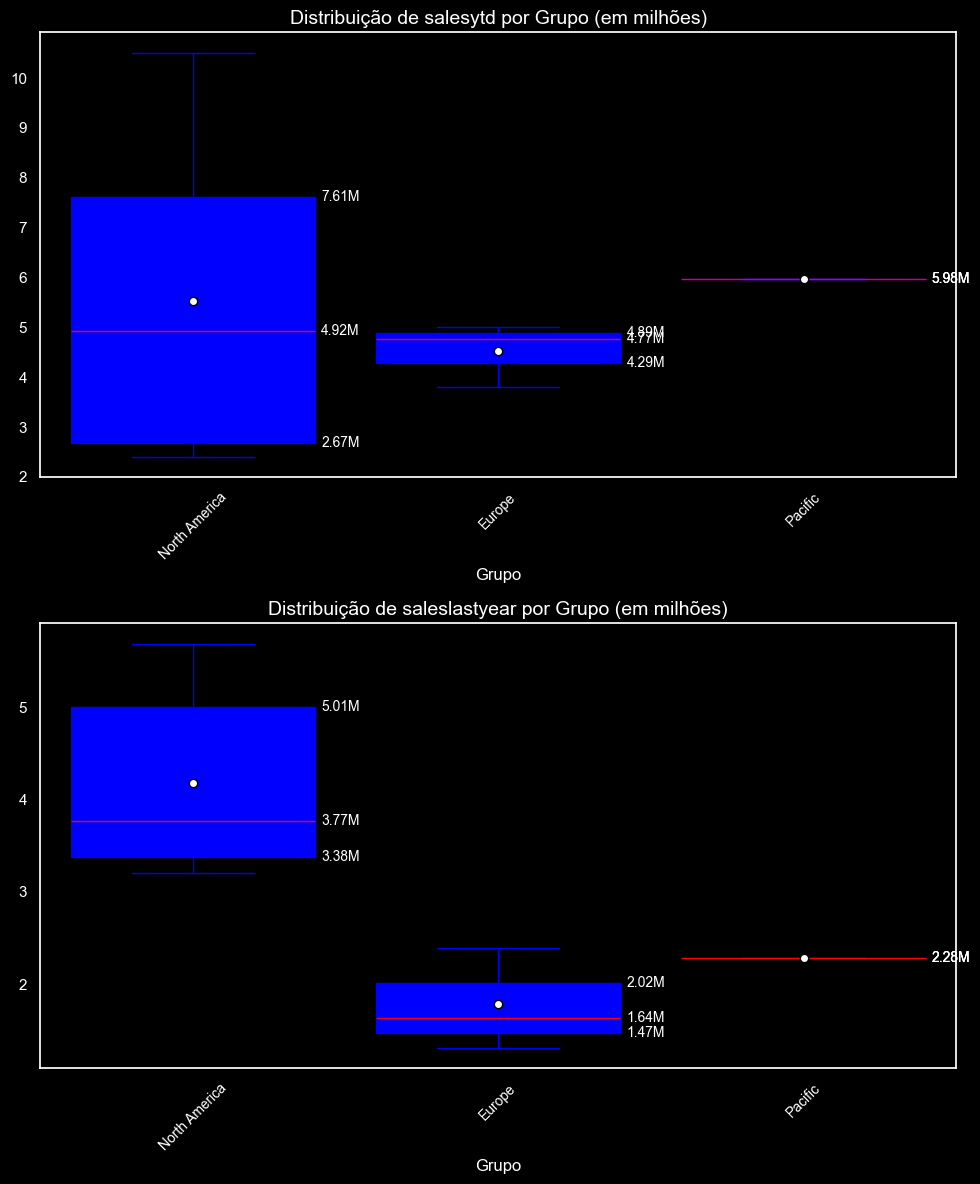

In [23]:
# Configurar o  gráfico
sns.set(style='darkgrid', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

# Lista das colunas para análise
columns_to_plot = ['salesytd', 'saleslastyear']

sales_salesterritory[columns_to_plot] = sales_salesterritory[columns_to_plot] / 1_000_000

fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 12))

for ax, col in zip(axes, columns_to_plot):
    quartiles = sales_salesterritory.groupby('group')[col].quantile([0.25, 0.50, 0.75]).unstack()
    sns.boxplot(
        x='group', y=col, data=sales_salesterritory, ax=ax, showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 6},
        boxprops={"color": "blue"}, whiskerprops={"color": "blue"}, capprops={"color": "blue"},
        medianprops={"color": "red"}, flierprops={"markerfacecolor": "yellow", "markersize": 6}
    )
    ax.set_title(f'Distribuição de {col} por Grupo (em milhões)', color='white', fontsize=14)
    ax.set_xlabel("Grupo", color='white', fontsize=12)
    ax.set_ylabel("", fontsize=12)  
    ax.tick_params(axis='x', colors='white', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', colors='white', left=False)  
    ax.grid(False)

    for group, values in quartiles.iterrows():
        if values.notnull().all(): 
            x_pos = list(sales_salesterritory['group'].unique()).index(group)  
            offset = 0.42
            for i, quartile in enumerate(values):
                y_pos = quartile
                ax.text(x=x_pos + offset, y=y_pos, s=f"{quartile:.2f}M", ha='left', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()

In [24]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['sales_salesterritory'] = sales_salesterritory

In [25]:
sales_salesterritory.head()

,territoryid,name,countryregioncode,group,salesytd,saleslastyear,rowguid,modifieddate
64,1,Northwest,US,North America,7.89,3.30,43689a10-e30b-497f-b0de-11de20267ff7,2008-04-30 00:00:00+00:00
77,2,Northeast,US,North America,2.40,3.61,00fb7309-96cc-49e2-8363-0a1ba72486f2,2008-04-30 00:00:00+00:00
90,3,Central,US,North America,3.07,3.21,df6e7fd8-1a8d-468c-b103-ed8addb452c1,2008-04-30 00:00:00+00:00
103,4,Southwest,US,North America,10.51,5.37,dc3e9ea0-7950-4431-9428-99dbcbc33865,2008-04-30 00:00:00+00:00
116,5,Southeast,US,North America,2.54,3.93,6dc4165a-5e4c-42d2-809d-4344e0ac75e7,2008-04-30 00:00:00+00:00


In [26]:
# Padronizar colunas com valores textuais
sales_salesterritory['name'] = sales_salesterritory['name'].str.strip().str.upper()
sales_salesterritory['countryregioncode'] = sales_salesterritory['countryregioncode'].str.strip().str.upper()
sales_salesterritory['group'] = sales_salesterritory['group'].str.strip().str.upper()
sales_salesterritory['rowguid'] = sales_salesterritory['rowguid'].str.strip().str.upper()

print(sales_salesterritory.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

     territoryid       name countryregioncode          group  salesytd  saleslastyear                               rowguid              modifieddate
64             1  NORTHWEST                US  NORTH AMERICA      7.89           3.30  43689A10-E30B-497F-B0DE-11DE20267FF7 2008-04-30 00:00:00+00:00
77             2  NORTHEAST                US  NORTH AMERICA      2.40           3.61  00FB7309-96CC-49E2-8363-0A1BA72486F2 2008-04-30 00:00:00+00:00
90             3    CENTRAL                US  NORTH AMERICA      3.07           3.21  DF6E7FD8-1A8D-468C-B103-ED8ADDB452C1 2008-04-30 00:00:00+00:00
103            4  SOUTHWEST                US  NORTH AMERICA     10.51           5.37  DC3E9EA0-7950-4431-9428-99DBCBC33865 2008-04-30 00:00:00+00:00
116            5  SOUTHEAST                US  NORTH AMERICA      2.54           3.93  6DC4165A-5E4C-42D2-809D-4344E0AC75E7 2008-04-30 00:00:00+00:00


In [27]:
# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
 
    output_table = f"{output_dataset}.{table_name}"
   
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela sales_salesterritory exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.sales_salesterritory.
